# Facebook Report Domain List Verification

The purpose of this notebook is to analyze the list of top domains provided by Facebook in their "transparency report Q2" with the corresponding top domain list from Citizen Browser during the same time. The hope is that we can use these two lists to show that our results are indeed correlated with the general trends seen on facebook in order to give us confidence in results we see from other parts of the data.

In [1]:
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import dataframe_image as dfi
from matplotlib.ticker import FormatStrFormatter

from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import rbo

from analysis import FBCBData, load_cb_unsponsored
from utils import save_tabular

In [3]:
data = FBCBData(load_cb=load_cb_unsponsored)

Found query cache: data/query_cache/cef87b364a3d5f1203b78616c03612e8.csv


First let's make the dataframe human readible to have a nice view for the methodology.

In [4]:
fbcb = data.joined_domains()
print(fbcb.info())
fbcb.index.names = ['Domain']
fbcb_clean = (fbcb
     .drop(columns=['Unnamed: 0'], errors='ignore')
     .rename(columns={
         "unique_users_cb": "Unique Users Markup",
         "rank_cb": "Ranking Markup",
         "rank_fb": "Ranking Facebook",
         "unique_users_fb": "Unique Users Facebook",
     })
     .head(20))
dfi.export(fbcb_clean, 'images/fig4.png')
fbcb_clean

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, youtube.com to vimeo.com
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Unnamed: 0       20 non-null     int64
 1   unique_users_cb  20 non-null     int64
 2   rank_cb          20 non-null     int64
 3   rank_fb          20 non-null     int64
 4   unique_users_fb  20 non-null     int64
dtypes: int64(5)
memory usage: 960.0+ bytes
None


[1101/122155.954240:ERROR:gpu_init.cc(453)] Passthrough is not supported, GL is swiftshader, ANGLE is 
[1101/122156.221311:INFO:headless_shell.cc(653)] Written to file /tmp/tmptqua8b8z/temp.png.


,Unique Users Markup,Ranking Markup,Ranking Facebook,Unique Users Facebook
Domain,,,,
youtube.com,1604,1,1,181300000000
amazon.com,1041,3,2,134600000000
unicef.org,865,7,3,134400000000
gofundme.com,761,12,4,124800000000
twitter.com,978,4,5,116100000000
media1.tenor.co,815,10,6,115600000000
m.tiktok.com,599,22,7,110700000000
open.spotify.com,639,18,8,93000000000
playeralumniresources.com,462,36,9,89900000000


In [5]:
data.joined_domains(how='outer').sort_values('rank_cb').head(20)

,Unnamed: 0,unique_users_cb,rank_cb,rank_fb,unique_users_fb
url_domain,,,,,
youtube.com,0,1604,1,1.0,1.813000e+11
facebook.com,1,1410,2,NaN,NaN
amazon.com,2,1041,3,2.0,1.346000e+11
twitter.com,3,978,4,5.0,1.161000e+11
nytimes.com,4,933,5,NaN,NaN
washingtonpost.com,5,892,6,NaN,NaN
unicef.org,6,865,7,3.0,1.344000e+11
nbcnews.com,7,851,8,15.0,8.310000e+10
cnn.com,8,843,9,16.0,8.280000e+10


## Domain Correlation

Let's look at the raw correlation between the domain rankings and the view counts. We assume that the p-values for the domain correlation is biased because the null hypothesis doesn't properlly consider our full ranking and only sees the partial, intesected, ranking with respect to the facebook report.

The domain correlation is done by taking the "ranking facebook" and "ranking markup" columns from the above dataframe and feeding them into scipy.stats.kendalltau.

The views correlation is done by taking the "Unique Users Markup" and "Unique Users Facebook" and feeding them into scipy.stats.spearmanr.

In [6]:
print("Domain Correlation:", data.correlation_domains())
print("Views Correlation:", data.correlation_views())

Domain Correlation: KendalltauResult(correlation=0.45263157894736844, pvalue=0.004748309856126978)
Views Correlation: SpearmanrResult(correlation=0.5889432533829471, pvalue=0.006291793725930202)


### P-Value Simulation

In order to calculate a more reasonable p-value, we sample from randomly generated full rankings of our domains and perform the same Kendall Tau correlation as above. The Markup's full ranking is shuffled, intersected with the Facebook ranking, and the correlation is performed (and outputted by the `random_sampler`). We are then able to calculate the one-sided p-value by seeing how many samples had a correlation lower than the correlation we calculate for our list.

In [7]:
corr_random = []
corr, p = data.correlation_domains()

random_sampler = data.correlation_domains_random()
for _ in tqdm(range(500_000)):
    c, _ = next(random_sampler)
    corr_random.append(c)

  0%|          | 0/500000 [00:00<?, ?it/s]

In [8]:
print("domains corr:", corr)
print("approx p:", p)
print("exact one-sided p:", sum(1 for c in corr_random if c >= corr) / len(corr_random))

domains corr: 0.45263157894736844
approx p: 0.004748309856126978
exact one-sided p: 0.002352


<IPython.core.display.Javascript object>


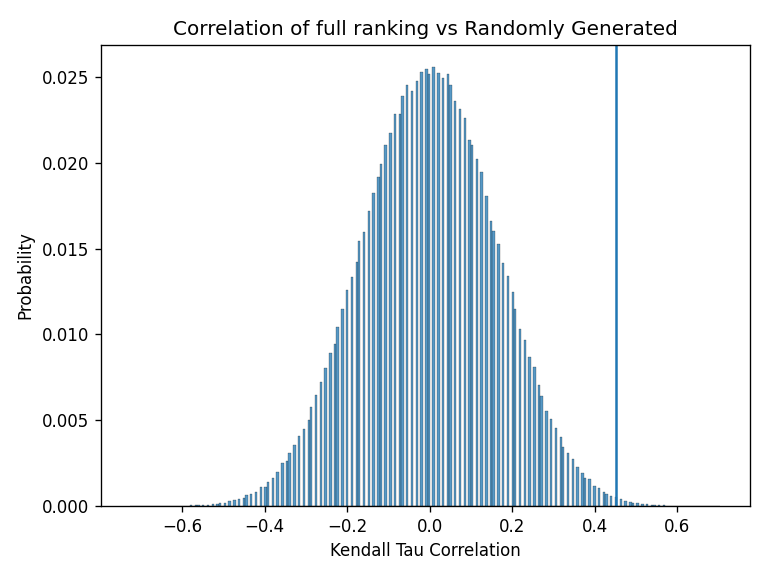

In [9]:
plt.figure()
sns.histplot(corr_random, stat='probability')
plt.axvline(corr)
plt.xlabel('Kendall Tau Correlation')
plt.title('Correlation of full ranking vs Randomly Generated')

plt.tight_layout()
plt.savefig("images/fig2.png")
plt.show()

For posterity, we also calculate the RBO coefficient to see how much the intersection of the lists effects the results

In [10]:
data.correlation_domains(method='rbo')

0.6369912465898435

### Data Visualization

We now dive a bit into the full dataset. Here, `df` is the full, non-intersected dataset. Note that all the `*_fb` fields are None except for those 20 domains from the facebook report.

In [11]:
df = data.joined_domains(how='outer')
df.describe()
df.head()

,Unnamed: 0,unique_users_cb,rank_cb,rank_fb,unique_users_fb
url_domain,,,,,
youtube.com,0,1604,1,1.0,1.813000e+11
amazon.com,2,1041,3,2.0,1.346000e+11
unicef.org,6,865,7,3.0,1.344000e+11
gofundme.com,11,761,12,4.0,1.248000e+11
twitter.com,3,978,4,5.0,1.161000e+11


<IPython.core.display.Javascript object>


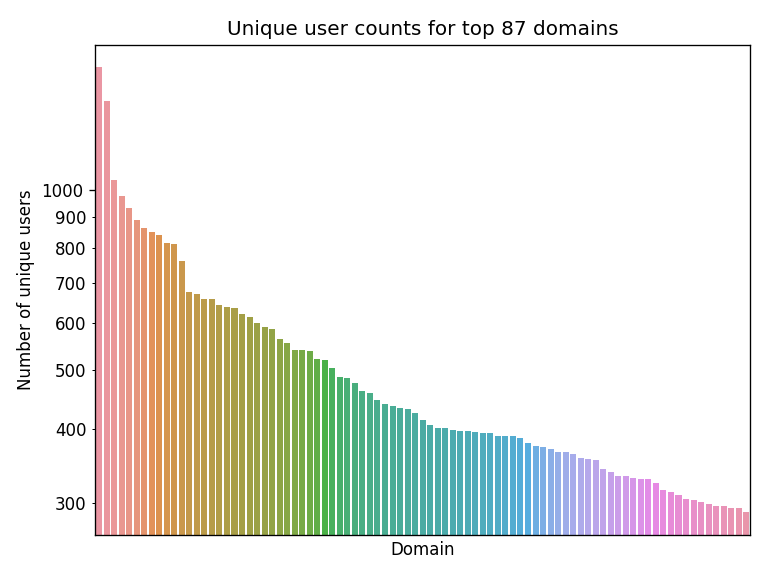

In [12]:
plt.figure()

ax = sns.barplot(data=df.head(87), x='rank_cb', y='unique_users_cb')
save_tabular("cb_top_87", df.head(87)[['rank_cb', 'unique_users_cb']])

ax.set_yscale('log')
ax.set_ylabel("Number of unique users")
ax.set_xlabel("Domain")
ax.set_title("Unique user counts for top 87 domains")
ax.set_xticks([])
ax.yaxis.set_minor_formatter(FormatStrFormatter("%.0f"))
ax.yaxis.set_major_formatter(FormatStrFormatter("%.0f"))
plt.tick_params(axis='y', which='minor')

plt.tight_layout()
plt.savefig("images/fig1a.png")
plt.show()

<IPython.core.display.Javascript object>


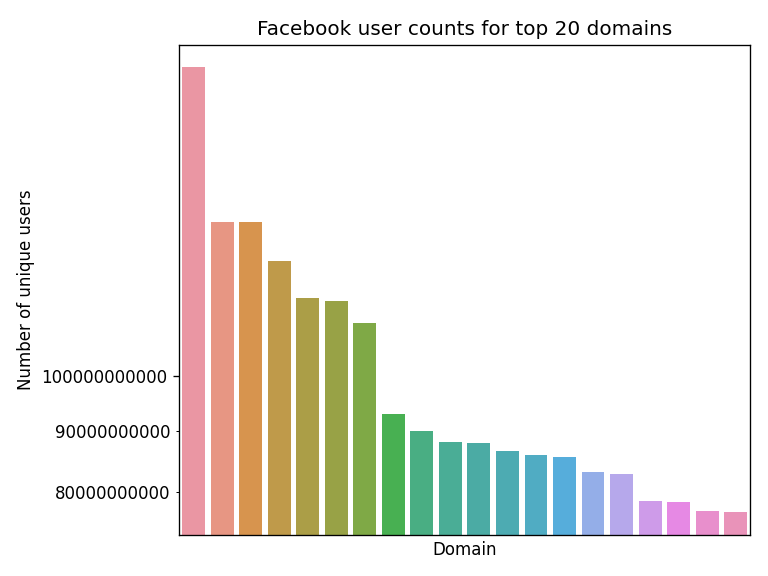

In [13]:
plt.figure()

ax = sns.barplot(data=fbcb.sort_values('rank_fb'), x='rank_fb', y='unique_users_fb')
save_tabular("fb_top_20", 
             fbcb.sort_values('rank_fb')[['rank_fb', 'unique_users_fb']])

ax.set_yscale('log')
ax.set_ylabel("Number of unique users")
ax.set_xlabel("Domain")
ax.set_title("Facebook user counts for top 20 domains")
ax.set_xticks([])

ax.yaxis.set_minor_formatter(FormatStrFormatter("%.0f"))
ax.yaxis.set_major_formatter(FormatStrFormatter("%.0f"))
plt.tick_params(axis='y', which='minor')

plt.tight_layout()
plt.savefig("images/fig1b.png")
plt.show()

### RBO Verification

For verification that the intersection of the two ranked lists isn't an overly biasing effect, we quickly calculate the [RBO](https://dl.acm.org/doi/abs/10.1145/1852102.1852106) of the two sets to make sure it is consistent with our results abobve

RBO Extrapolated (Eq. (32) from paper): 0.6306900298274583
RBO Default: 0.5346698648788433


<IPython.core.display.Javascript object>


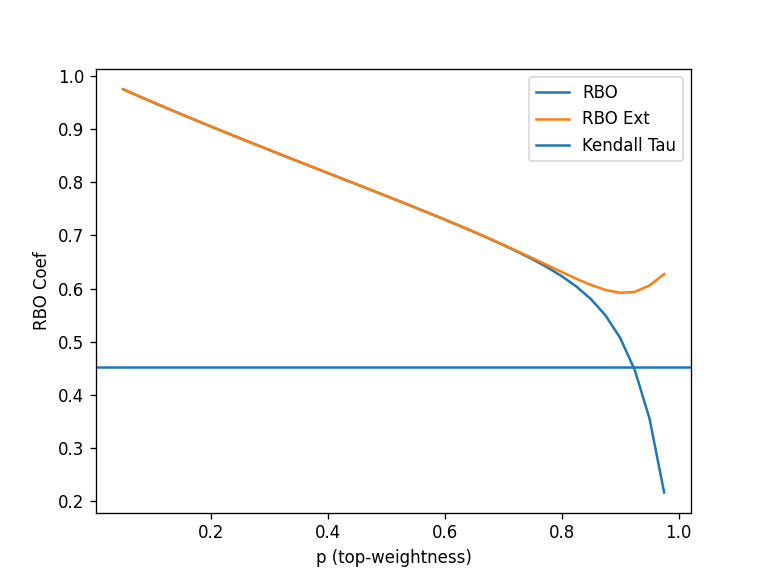

In [14]:
cb = df.sort_values('rank_cb').index.to_list()
fb = df.query('rank_fb > 0').sort_values('rank_fb').index.to_list()
corr, _ = data.correlation_domains()

r = rbo.RankingSimilarity(cb, fb)
print("RBO Extrapolated (Eq. (32) from paper):", r.rbo_ext())
print("RBO Default:", r.rbo())

P = np.arange(0.05, 1, 0.025)
Y = [r.rbo(p=p) for p in P]
Y_ext = [r.rbo_ext(p=p) for p in P]

f = plt.figure()
plt.plot(P, Y, label='RBO')
plt.plot(P, Y_ext, label='RBO Ext')
# note: rbo and kendall aren't directly comparable, but it's a good smell test
plt.axhline(y=corr, label='Kendall Tau')
plt.legend()

plt.xlabel("p (top-weightness)")
plt.ylabel("RBO Coef")
plt.show()

## Views Correlation

Now just a quick dive into the correlation between the viewership numbers from the facebook report.

In [15]:
data.correlation_views()

SpearmanrResult(correlation=0.5889432533829471, pvalue=0.006291793725930202)

<IPython.core.display.Javascript object>


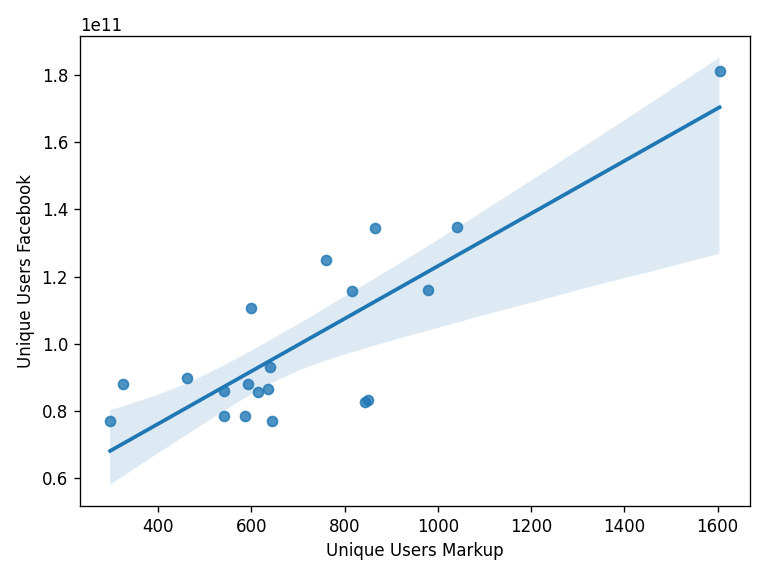

In [16]:
plt.figure()
g = sns.regplot(data=fbcb, 
                x='unique_users_cb', 
                y='unique_users_fb',
                n_boot=10_000)
g.set_ylabel('Unique Users Facebook')
g.set_xlabel('Unique Users Markup')

plt.tight_layout()
plt.savefig("images/fig3.png")
plt.show()

In [17]:
a = np.vstack([
    fbcb.unique_users_cb.to_numpy(),
    np.ones(20)
]).T
b = fbcb.unique_users_fb.to_numpy()[..., np.newaxis]
m, b = np.linalg.lstsq(a, b, rcond=-1)[0]
print("slope:", m)
print("int:", b)

slope: [78271209.90916052]
int: [4.48493799e+10]


# Domains with high viewership users

In [18]:
df_hfu = data.high_frequency_users()

Found query cache: data/query_cache/cf92a50acb57931b205aa600ae85836e.csv


In [19]:
df_hfu.sample(n=10)

,Unnamed: 0,url_domain,user_id,n_views
310053,310053,virtu.academy,ef92d99a13938d5124a8975aaa8517d0,6
294170,294170,trailersfromhell.com,304621ba1597930b7127769d00c1a87e,2
126414,126414,holley.com,6e0a3cd5cf9239cd9618ecf28ce7f3f7,1
70503,70503,dannyfernandes.netlify.app,5881ef52cbf5d86ad45af62453218e56,5
16554,16554,annwilson.com,e3028ca9a11fe24b2015fb687fcee1a2,1
131760,131760,ign.com,52e61c1ba7c65a5c25faa786b4460b3f,1
231394,231394,raskin.house.gov,1b73f99ce39dfed1b91667e0491d906d,1
297861,297861,tvone.tv,da95dc67a0d7aca7339a96bf7157bbb7,2
62842,62842,cordcuttersnews.com,f8c025cdbeed8fd9e02c89080dc74274,3
95561,95561,fb1.farm2.zynga.com,90c766e1eb421ad5dac94214a02167c0,1


In [20]:
df_hfu.describe()

,Unnamed: 0,n_views
count,333688.00000,333688.000000
mean,166843.50000,3.639184
std,96327.57265,21.318328
min,0.00000,1.000000
25%,83421.75000,1.000000
50%,166843.50000,1.000000
75%,250265.25000,2.000000
max,333687.00000,4095.000000


We group by url_domain and do some aggregate statistics. We define a "High View User" as someone who saw a domain more than 90 times in our sample period. This represents seeing the domain at least once per day.

In [21]:
dg = df_hfu.groupby('url_domain')
domains = (
    dg
        .agg({
            "n_views": lambda d: (d > 90).sum(),
        })
        .sort_values("n_views", ascending=False)
        .head(1000)
        .rename(columns={"n_views": "n_high_viewers"})
    .merge(
        dg
            .agg({"n_views": "count"})
            .sort_values("n_views", ascending=False)
            .head(1000)
            .rename(columns={'n_views': 'n_users'}),
        right_index=True,
        left_index=True,
        how='outer',
    )
)
domains['frac_high_viewers'] = domains.n_high_viewers / domains.n_users
domains.describe()

,n_high_viewers,n_users,frac_high_viewers
count,1000.000000,1000.000000,241.000000
mean,1.278000,126.316000,0.017866
std,6.433203,145.067173,0.014698
min,0.000000,42.000000,0.000000
25%,0.000000,55.000000,0.007752
50%,1.000000,76.000000,0.014925
75%,1.000000,131.000000,0.021739
max,172.000000,1604.000000,0.107232


In [22]:
def get_domain_samples_raw(df, domains, field, N=25):
    return (
        domains
            .sort_values(field, ascending=False)
            .head(N)
            .reset_index()
            .merge(df, on='url_domain')
    )

def get_domain_samples(domains, field, N=25):
    return domains.sort_values(field, ascending=False).head(N).reset_index()

<IPython.core.display.Javascript object>


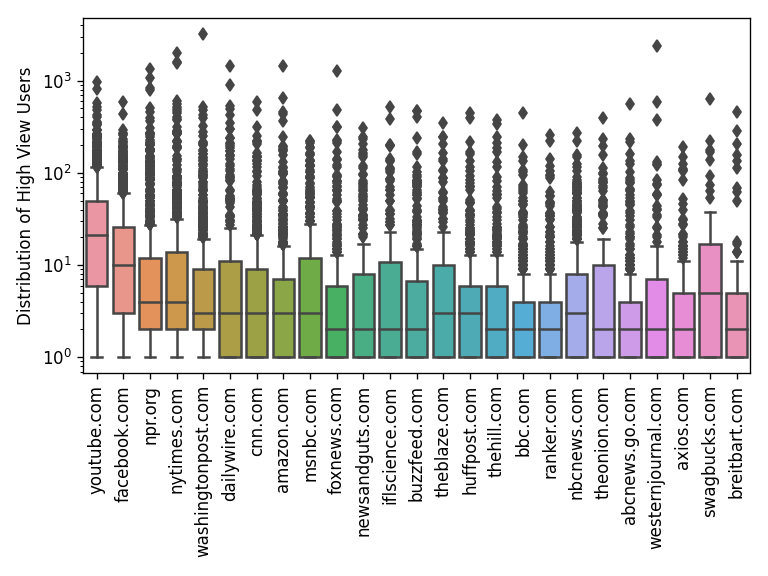

In [23]:
d = get_domain_samples_raw(df_hfu, domains, 'n_high_viewers')

plt.figure()
ax = sns.boxplot(data=d, x='url_domain', y='n_views')
plt.xticks(rotation='vertical')
ax.set_yscale('log')
plt.xlabel('')
plt.ylabel('Distribution of High View Users')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


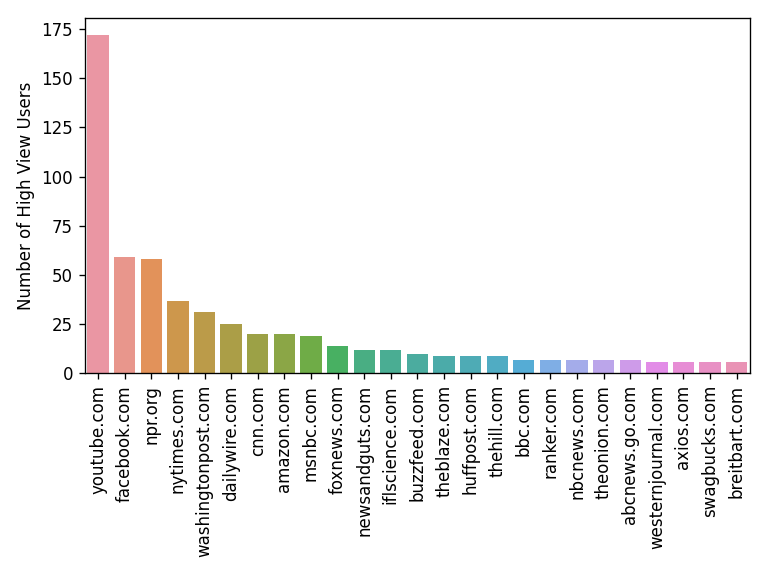

In [24]:
d = get_domain_samples(domains, 'n_high_viewers')

plt.figure()
sns.barplot(data=d, x='url_domain', y='n_high_viewers')
save_tabular('n_high_viewers', d[['url_domain', 'n_high_viewers']])
plt.xlabel('')
plt.ylabel('Number of High View Users')
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


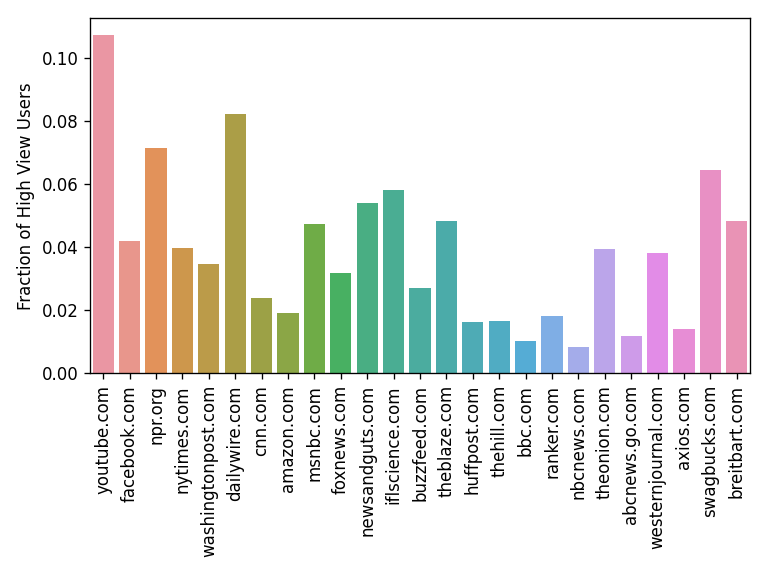

In [25]:
d = get_domain_samples(domains, 'n_high_viewers')

plt.figure()
sns.barplot(data=d, x='url_domain', y='frac_high_viewers')
save_tabular('n_high_viewers_by_frac', d[['url_domain', 'frac_high_viewers']])

plt.xlabel('')
plt.ylabel('Fraction of High View Users')
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


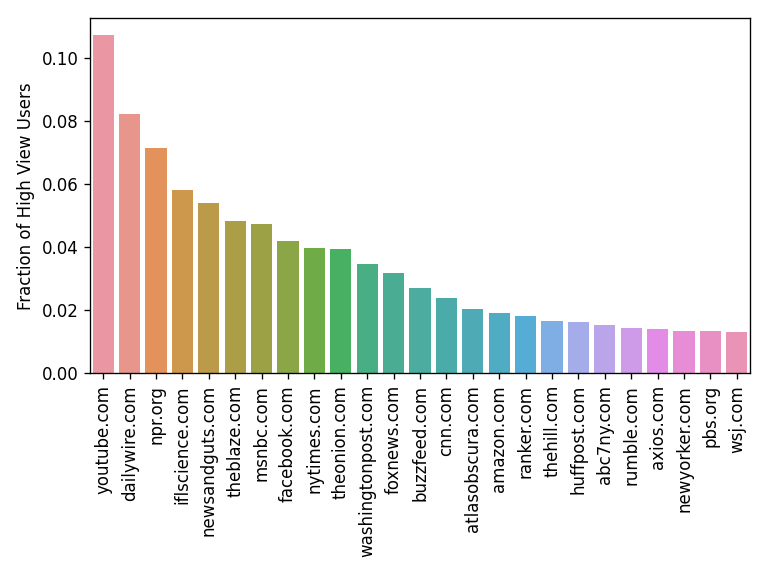

In [26]:
Q = df_hfu.groupby('url_domain').sum().reset_index().n_views.quantile(0.99)
d = get_domain_samples(
    domains.query('n_users > @Q'),
    'frac_high_viewers'
)

plt.figure()
sns.barplot(data=d, x='url_domain', y='frac_high_viewers')
save_tabular('frac_high_viewers_99pct', d[['url_domain', 'frac_high_viewers']])
plt.xlabel('')
plt.ylabel('Fraction of High View Users')
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


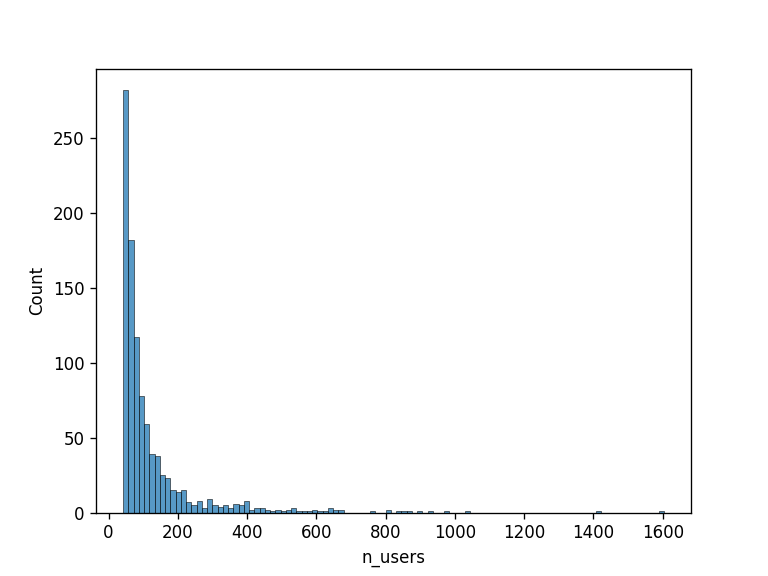

In [27]:
plt.figure()
sns.histplot(data=domains, x='n_users')
plt.show()

### Now let's look at just news domains

In [28]:
domains_news = data.filter_news_sources(domains)

<IPython.core.display.Javascript object>


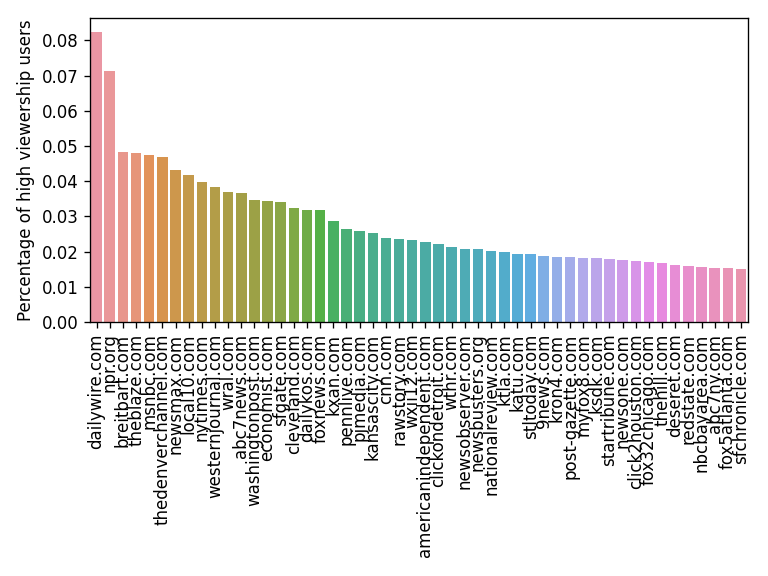

In [29]:
d = get_domain_samples(
    domains_news,
    'frac_high_viewers',
    N=50
)

plt.figure()
sns.barplot(data=d,
            x='url_domain',
            y='frac_high_viewers',
           )
save_tabular('news_frac_high_viewers', d[['url_domain', 'frac_high_viewers']])
plt.xlabel('')
plt.ylabel('Percentage of high viewership users')
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

# Additional Analysis

We look at the two-sample Kolmogorov-Smirnov test between the top 20 facebook domain views and top 20 markup domain views to make sure they come from similar distributions. This gives us an idea of whether the underlying data of views is coming from comparable distributions

<IPython.core.display.Javascript object>


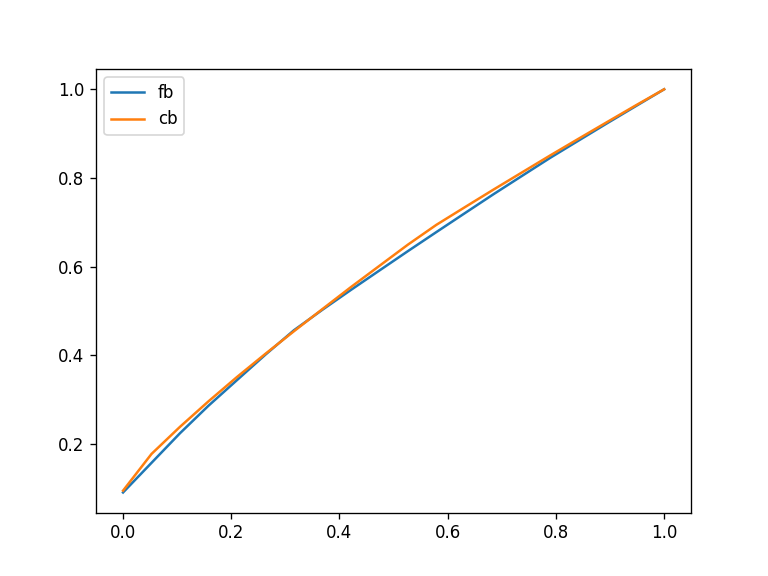

KstestResult(statistic=1.0, pvalue=1.4508889103849681e-11)

In [30]:
import numpy as np

def norm_cumsum(df):
    df = df.cumsum()
    return df / df.max()

cbfb = data.joined_domains(how='outer')
fb = cbfb.query('rank_fb > 0').sort_values('rank_fb').head(20).unique_users_fb
cb = cbfb.query('rank_cb > 0').sort_values('rank_cb').head(20).unique_users_cb

fb_cdf = norm_cumsum(fb)
cb_cdf = norm_cumsum(cb)

plt.figure()
plt.plot(np.linspace(0, 1, len(fb_cdf)), fb_cdf, label='fb')
plt.plot(np.linspace(0, 1, len(cb_cdf)), cb_cdf, label='cb')
plt.legend()
plt.show()

from scipy import stats
stats.ks_2samp(fb, cb)